In [158]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [159]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [160]:
ALPHABET_SIZE = 27
all_chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(all_chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}

In [161]:
# let's prepare the data
BLOCK_SIZE = 3
def build(words):
    X = []
    Y = []
    for word in words:
        context = [0] * BLOCK_SIZE
        for letter in word + '.':
            letter_index = stoi[letter]
            X.append(context[:])
            Y.append(letter_index)
            context = context[1:] + [letter_index]
    return torch.tensor(X), torch.tensor(Y)

X, Y = build(words)

In [162]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
EMBEDDING_SIZE = 10
C = torch.randn((ALPHABET_SIZE, EMBEDDING_SIZE), generator=g, requires_grad=True)

In [163]:
HIDDEN_LAYER_OUTPUTS = 200
W1 = torch.randn((EMBEDDING_SIZE * BLOCK_SIZE, HIDDEN_LAYER_OUTPUTS), generator=g, requires_grad=True)
b1 = torch.randn((HIDDEN_LAYER_OUTPUTS), generator=g, requires_grad=True)

In [169]:
W2 = torch.randn((HIDDEN_LAYER_OUTPUTS, ALPHABET_SIZE), generator=g, requires_grad=True)
b2 = torch.randn((ALPHABET_SIZE), generator=g, requires_grad=True)

torch.Size([27])

In [165]:
parameters = [C, W1, b1, W2, b2]

In [166]:
def step(X, Y):
    # forward pass
    embeddings = C[X]
    hidden_outputs = (embeddings.view(-1, EMBEDDING_SIZE * BLOCK_SIZE) @ W1 + b1).tanh()
    outputs = hidden_outputs @ W2 + b2
    loss = F.cross_entropy(outputs, Y)

    # backward pass
    for param in parameters:
        param.grad = None
    
    loss.backward()

    # update params
    LEARNING_RATE = 0.1
    for param in parameters:
        param.data += -LEARNING_RATE * param.grad
    return loss.item()

In [167]:
steps = []
losses = []

Step 0: loss 26.00634002685547
Step 50: loss 9.886689186096191


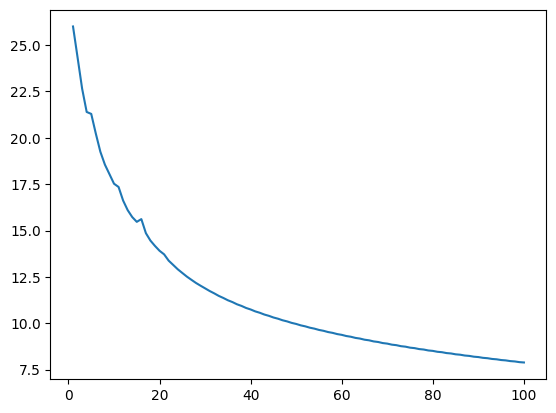

In [168]:
for step_num in range(100):
    steps.append(len(steps) + 1)
    loss = step(X, Y)
    losses.append(loss)
    if step_num % 50 == 0:
        print(f"Step {step_num}: loss {loss}")

plt.plot(steps, losses)